First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [1]:
#!conda create -n BI2025 python=3.11 -y
#!conda activate BI2025
#!pip install -r requirements.txt

In [2]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
from starvers.starvers import TripleStoreEngine

## Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [3]:
executed_by ='stud-id_12205610'  # Replace the digits after "id_" with your own student ID

Set your group and student IDs. Do this only once.

In [4]:
# group id for this project
group_id = '84'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_12205610'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_76543210'  # Replace the digits after "id_" with student B's student ID

In [5]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [6]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [7]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    'unit': 'http://qudt.org/vocab/unit/', # Added by student_a
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [8]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [9]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Jonathan" .',
f':{student_a} foaf:familyName "Maier" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "12205610" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "01234567"^^xsd:string .',
]

reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "Morgan" .',
f':{student_b} foaf:familyName "Stern" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "76543210"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]


engine.insert(reigstration_triples_a, prefixes=prefixes)
engine.insert(reigstration_triples_b, prefixes=prefixes)
engine.insert(role_triples, prefixes=prefixes)

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

## Business Understanding 

In [10]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [11]:
#############################################
# Documentation
#############################################

data_src_and_scenario_comment = """
Scenario:       We founded the Company "Fritz & Maier AG" after our Bachelors, which is a software company that has scaled rapidly to hundreds of employees that are located all over the world. 
                Due to this rapid expansion, the current compensation structure is ad-hoc, resulting in internal pay inequities and potential misalignment with the current market. 
                As the company matures and growes even further, HR requires a data-driven approach to standardize these salaries. 
                The goal is to use the Stack Overflow data to analyze the relationship between skills, experience, and education against compensation to benchmark current employee salaries make adaptions for the following business year.

Data Source:    The analysis utilizes the Stack Overflow Annual Developer Survey 2025. 
                This dataset contains comprehensive information regarding developer demographics, experience, technology usage, and compensation from a global audience.

"""

business_objectives_comment = """
The primary objective is to establish a data-driven salary benchmarking model to find a fair market value for software engineering roles based on objective factors such as experience, location and their tech stack.

Secondary Objectives:
1. Identify current employees who may be significantly under- or overpaid compared to the market.
2. Standardize salary offers for new hires to reduce negotiation time.
3. Ensure the company's budget is optimized by avoiding arbitrary overpayment while maintaining competitiveness.
"""

business_success_criteria_comment = """
1. Salary Model Adoption: The HR department successfully adopts the model to review at least 80% of current employee contracts.
2. Turnover Reduction: A measurable reduction in staff turnover attributed to compensation issues.
3. Offer Acceptance: An increase in the acceptance rate of initial job offers for new hires, indicating that the data-backed offers are competitive.
5. Budget Optimization: Achieving a total salary budget that aligns within +/- 10% of the predicted market benchmark, ensuring the company is neither overspending nor significantly underpaying.
6. Faster Time-to-Hire: A reduction in the average time required to close a candidate, specifically by shortening the salary negotiation phase through transparent, data-backed offers.
"""

data_mining_goals_comment = """
...
"""

data_mining_success_criteria_comment = """
...
"""

ai_risk_aspects_comment = """
...
"""

bu_ass_uuid_executor = "bb6a40f9-9d92-4f9f-bbd2-b65ef6a82da2" # Generate once
business_understanding_executor = [
f':business_understanding rdf:type prov:Activity .',
f':business_understanding sc:isPartOf :business_understanding_phase .', # Connect Activity to Parent Business Understanding Phase Activity
f':business_understanding prov:qualifiedAssociation :{bu_ass_uuid_executor} .',
f':{bu_ass_uuid_executor} prov:agent :{executed_by} .',
f':{bu_ass_uuid_executor} rdf:type prov:Association .',
f':{bu_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_executor, prefixes=prefixes)


business_understanding_data_executor = [
# 1a
f':bu_data_source_and_scenario rdf:type prov:Entity .',
f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
# 1b
f':bu_business_objectives rdf:type prov:Entity .',
f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
f':bu_business_objectives rdfs:label "1b Business Objectives" .',
f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
# 1c
f':bu_business_success_criteria rdf:type prov:Entity .',
f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
# 1d
f':bu_data_mining_goals rdf:type prov:Entity .',
f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
# 1e
f':bu_data_mining_success_criteria rdf:type prov:Entity .',
f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
# 1f
f':bu_ai_risk_aspects rdf:type prov:Entity .',
f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
engine.insert(business_understanding_data_executor, prefixes=prefixes)

## Data Understanding

In [12]:
## Each Activity that follows is part of the Data Understanding Phase

business_understanding_phase_executor = [
    f':data_understanding_phase rdf:type prov:Activity .',
    f':data_understanding_phase rdfs:label "Data Understanding Phase" .', 
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


#### Data Schema and Layout
Before we dive deeper into the identified issues, the following section provides a brief overview of the data structure.

In [13]:
import re

survey_data_path = os.path.join("data", "stack-overflow-developer-survey-2025")
load_survey_data_code_writer = student_a
def load_survey_data()-> pd.DataFrame:
    ### Load your data
    input_file = os.path.join(survey_data_path, 'survey_results_public.csv')
    return pd.read_csv(input_file,  sep=',', header = 0, low_memory=False)

def load_survey_schema() -> pd.DataFrame:
    ### Load your data schema
    schema_file = os.path.join(survey_data_path, 'survey_results_schema.csv')
    return pd.read_csv(schema_file, sep=',', header=0, low_memory=False)
    
start_time_ld = now()
data = load_survey_data()
schema = load_survey_schema()
end_time_ld = now()

# show all columns for this display only
with pd.option_context('display.max_columns', None):
    print("Schema:")
    display(schema.head())
    print("\n\nData:")
    display(data.head())


#############################################
# Documentation 
# DISCLAIMER: Provided Gemini with Schema and Head of Data -> Prompt:
#   Here in this section I have to document my steps with  PROV-O. I shared the frist few lines of my dataset as well as the schema that describes each column.
#   Pleaes use that information to create the documentation of the data loading step according to PROV-O.
#   As we have a lot of columns please automate the generation of the field definitions based on the schema and the data types found in the data.
# -> This produced an almost working implemention, which I then fixed and adapted to fit the requirements. (Issues with automated loop)
#############################################

# Now document the raw data and the loaded data using appropriate ontologies.

# Always add these triples for every activity to define the executor!
ld_ass_uuid_executor = "b8bac193-c4e6-4e31-9134-b23e001e279c" # Generate once
load_survey_data_executor = [
    f':load_survey_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
# 1. Define the Activity (Provenance)
ld_ass_uuid_writer = "c600e15c-87a9-4e2a-be85-b6c2a3014210" # Fixed UUID
ld_report = "Load Stack Overflow 2025 Survey Data and Schema CSVs into Pandas DataFrames."

load_survey_activity = [
    # Activity Definition
    ':load_survey_data rdf:type prov:Activity .',
    ':load_survey_data sc:isPartOf :data_understanding_phase .',
    ':load_survey_data rdfs:label "Load Survey Data" .',
    f':load_survey_data rdfs:comment """{ld_report}""" .',
    f':load_survey_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_survey_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',
    
    # Agent Association (Writer)
    f':load_survey_data prov:qualifiedAssociation :{ld_ass_uuid_writer} .',
    f':{ld_ass_uuid_writer} prov:agent :{load_survey_data_code_writer} .',
    f':{ld_ass_uuid_writer} rdf:type prov:Association .',
    f':{ld_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # Inputs (The Files)
    ':load_survey_data prov:used :survey_csv_file .',
    ':load_survey_data prov:used :schema_csv_file .',
    
    # Outputs (The Loaded Data Entity)
    ':loaded_survey_data rdf:type prov:Entity .',
    ':loaded_survey_data prov:wasGeneratedBy :load_survey_data .',
    ':loaded_survey_data prov:wasDerivedFrom :survey_csv_file .',
]
engine.insert(load_survey_activity, prefixes=prefixes)

# 2. Define the File Assets (Croissant)
file_asset_triples = [
    # Main Data File
    ':survey_csv_file rdf:type cr:FileObject .',
    ':survey_csv_file sc:name "survey_results_public.csv" .',
    ':survey_csv_file sc:description "Raw survey responses from Stack Overflow 2025" .',
    ':survey_csv_file sc:encodingFormat "text/csv" .',
    
    # Schema File
    ':schema_csv_file rdf:type cr:FileObject .',
    ':schema_csv_file sc:name "survey_results_schema.csv" .',
    ':schema_csv_file sc:description "Metadata and question definitions" .',
    ':schema_csv_file sc:encodingFormat "text/csv" .',
]
engine.insert(file_asset_triples, prefixes=prefixes)

# 3. Define the Dataset Schema (Dynamic Generation)
dataset_triples = [
    ':loaded_survey_data rdf:type sc:Dataset .',
    ':loaded_survey_data sc:name "Stack Overflow Developer Survey 2025" .',
    ':loaded_survey_data sc:description "Public results of the annual developer survey." .',
    ':loaded_survey_data sc:distribution :survey_csv_file .',
    
    # Define the RecordSet
    ':survey_recordset rdf:type cr:RecordSet .',
    ':survey_recordset sc:name "Survey Responses" .',
    ':loaded_survey_data cr:recordSet :survey_recordset .',
]

# --- AUTOMATED FIELD GENERATION ---
# Loop through dataframe columns to create field definitions
for col_name in data.columns:
    # === FIX: Sanitize the node ID ===
    # We replace anything that is NOT a letter, number, or underscore with an underscore
    # This handles spaces, dots, single quotes ('), question marks, etc.
    safe_col_id = re.sub(r'[^a-zA-Z0-9_]', '_', col_name)
    field_node = f":field_{safe_col_id}"
    
    # Get description from Schema DF if available
    try:
        desc = "No description available"
        if col_name in schema['qname'].values:
            desc = schema.loc[schema['qname'] == col_name, 'question'].values[0]
        else:
            # Fallback for matrix sub-columns
            for q in sorted(schema['qname'].astype(str), key=len, reverse=True):
                if col_name.startswith(q):
                    desc = schema.loc[schema['qname'] == q, 'question'].values[0]
                    break
        
        # Clean text for RDF (Escape quotes and remove newlines)
        desc = desc.replace('"', "'").replace('\n', ' ')[:200]
    except:
        desc = "Description lookup failed"

    # Infer XSD Data Type from Pandas Dtype
    dtype = data[col_name].dtype
    xsd_type = "xsd:string"
    if pd.api.types.is_integer_dtype(dtype):
        xsd_type = "xsd:integer"
    elif pd.api.types.is_float_dtype(dtype):
        xsd_type = "xsd:double"
    elif pd.api.types.is_bool_dtype(dtype):
        xsd_type = "xsd:boolean"

    # Add Field Triples
    dataset_triples.append(f':survey_recordset cr:field {field_node} .')
    dataset_triples.append(f'{field_node} rdf:type cr:Field .')
    dataset_triples.append(f'{field_node} sc:name "{col_name}" .') # Keep original name here
    dataset_triples.append(f'{field_node} sc:description "{desc}" .')
    dataset_triples.append(f'{field_node} cr:dataType {xsd_type} .')

    # Optional: Add QUDT Units for specific columns
    if col_name == 'ConvertedCompYearly':
         dataset_triples.append(f'{field_node} qudt:unit unit:US_Dollar .')
    elif col_name in ['WorkExp', 'YearsCode']:
         dataset_triples.append(f'{field_node} qudt:unit unit:Year .')

# Insert the massive list of triples
engine.insert(dataset_triples, prefixes=prefixes)
print("Documentation complete: Survey Data loaded and schema defined.")

Schema:


,qid,qname,question,type,sub,sq_id
0,QID18,TechEndorse_1,What attracts you to a technology or causes yo...,RO,AI integration or AI Agent capabilities,1.0
1,QID18,TechEndorse_2,What attracts you to a technology or causes yo...,RO,Easy-to-use API,2.0
2,QID18,TechEndorse_3,What attracts you to a technology or causes yo...,RO,Robust and complete API,3.0
3,QID18,TechEndorse_4,What attracts you to a technology or causes yo...,RO,Customizable and manageable codebase,4.0
4,QID18,TechEndorse_5,What attracts you to a technology or causes yo...,RO,Reputation for quality,5.0




Data:


,ResponseId,MainBranch,Age,EdLevel,Employment,EmploymentAddl,WorkExp,LearnCodeChoose,LearnCode,LearnCodeAI,AILearnHow,YearsCode,DevType,OrgSize,ICorPM,RemoteWork,PurchaseInfluence,TechEndorseIntro,TechEndorse_1,TechEndorse_2,TechEndorse_3,TechEndorse_4,TechEndorse_5,TechEndorse_6,TechEndorse_7,TechEndorse_8,TechEndorse_9,TechEndorse_13,TechEndorse_13_TEXT,TechOppose_1,TechOppose_2,TechOppose_3,TechOppose_5,TechOppose_7,TechOppose_9,TechOppose_11,TechOppose_13,TechOppose_16,TechOppose_15,TechOppose_15_TEXT,Industry,JobSatPoints_1,JobSatPoints_2,JobSatPoints_3,JobSatPoints_4,JobSatPoints_5,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,JobSatPoints_13,JobSatPoints_14,JobSatPoints_15,JobSatPoints_16,JobSatPoints_15_TEXT,AIThreat,NewRole,ToolCountWork,ToolCountPersonal,Country,Currency,CompTotal,LanguageChoice,LanguageHaveWorkedWith,LanguageWantToWorkWith,LanguageAdmired,LanguagesHaveEntry,LanguagesWantEntry,DatabaseChoice,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,DatabaseAdmired,DatabaseHaveEntry,DatabaseWantEntry,PlatformChoice,PlatformHaveWorkedWith,PlatformWantToWorkWith,PlatformAdmired,PlatformHaveEntry,PlatformWantEntry,WebframeChoice,WebframeHaveWorkedWith,WebframeWantToWorkWith,WebframeAdmired,WebframeHaveEntry,WebframeWantEntry,DevEnvsChoice,DevEnvsHaveWorkedWith,DevEnvsWantToWorkWith,DevEnvsAdmired,DevEnvHaveEntry,DevEnvWantEntry,SOTagsHaveWorkedWith,SOTagsWantToWorkWith,SOTagsAdmired,SOTagsHaveEntry,SOTagsWant Entry,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackAsyncAdmired,OfficeStackHaveEntry,OfficeStackWantEntry,CommPlatformHaveWorkedWith,CommPlatformWantToWorkWith,CommPlatformAdmired,CommPlatformHaveEntr,CommPlatformWantEntr,AIModelsChoice,AIModelsHaveWorkedWith,AIModelsWantToWorkWith,AIModelsAdmired,AIModelsHaveEntry,AIModelsWantEntry,SOAccount,SOVisitFreq,SODuration,SOPartFreq,SO_Dev_Content,SO_Actions_1,SO_Actions_16,SO_Actions_3,SO_Actions_4,SO_Actions_5,SO_Actions_6,SO_Actions_9,SO_Actions_7,SO_Actions_10,SO_Actions_15,SO_Actions_15_TEXT,SOComm,SOFriction,AISelect,AISent,AIAcc,AIComplex,AIToolCurrently partially AI,AIToolDon't plan to use AI for this task,AIToolPlan to partially use AI,AIToolPlan to mostly use AI,AIToolCurrently mostly AI,AIFrustration,AIExplain,AIAgents,AIAgentChange,AIAgent_Uses,AgentUsesGeneral,AIAgentImpactSomewhat agree,AIAgentImpactNeutral,AIAgentImpactSomewhat disagree,AIAgentImpactStrongly agree,AIAgentImpactStrongly disagree,AIAgentChallengesNeutral,AIAgentChallengesSomewhat disagree,AIAgentChallengesStrongly agree,AIAgentChallengesSomewhat agree,AIAgentChallengesStrongly disagree,AIAgentKnowledge,AIAgentKnowWrite,AIAgentOrchestration,AIAgentOrchWrite,AIAgentObserveSecure,AIAgentObsWrite,AIAgentExternal,AIAgentExtWrite,AIHuman,AIOpen,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,25-34 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed,"Caring for dependents (children, elderly, etc.)",8.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",AI CodeGen tools or AI-enabled apps,14.0,"Developer, mobile",20 to 99 employees,People manager,Remote,"Yes, I influenced the purchase of a substantia...",Work,10.0,7.0,9.0,6.0,3.0,11.0,12.0,1.0,8.0,14.0,NaN,15.0,7.0,8.0,12.0,11.0,1.0,6.0,13.0,3.0,16.0,NaN,Fintech,3.0,1.0,4.0,9.0,5.0,10.0,12.0,11.0,2.0,6.0,7.0,13.0,14.0,15.0,8.0,NaN,I'm not sure,I have neither consider or transitioned into a...,7.0,3.0,Ukraine,EUR European Euro,52800.0,Yes,Bash/Shell (all shells);Dart;SQL,Dart,Dart,NaN,NaN,Yes,Cloud Firestore;PostgreSQL,NaN,NaN,NaN,NaN,Yes,Amazon Web Services (AWS);Cloudflare;Firebase;...,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,Yes,Android Studio;Notepad++;Visual Studio;Visual ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Windows;MacOS;Android,Windows;MacOS;Android;iOS;iPadOS,Confluence;GitHub;GitLab;Jira;Markdo

Documentation complete: Survey Data loaded and schema defined.


### Understanding the Question Schemas

To facilitate a systematic understanding of the dataset structure, we utilize the auxiliary `survey_results_schema.csv` file. This metadata file provides essential context for each column in the primary dataset, specifically defining the 'type' of question associated with each feature. By mapping these types to our data columns, we can categorize features into logical groups for appropriate analysis and preprocessing.

The schema identifies four primary question types:

1.  **Rank Order (RO):** Questions where respondents rank items by preference or importance (e.g., '1' = Most Important).
2.  **Matrix:** Questions allowing multiple selections from a list, often resulting in semicolon-separated string values.
3.  **Text Entry (TE):** Open-ended fields that may contain either unstructured free text or numeric input that requires cleaning.
4.  **Multiple Choice (MC):** Categorical questions where respondents select a single option from a predefined list.

In [14]:
# Group the schema by 'type' and print the column names for each
for q_type, group in schema.groupby('type'):
    cols = group['qname'].unique().tolist()
    print(f"\n### Question Type: {q_type} ({len(cols)} columns) ###")
    print(cols)


### Question Type: MC (48 columns) ###
['MainBranch', 'Age', 'EdLevel', 'Employment', 'EmploymentAddl', 'LearnCodeChoose', 'LearnCode', 'LearnCodeAI', 'AILearnHow', 'DevType', 'OrgSize', 'ICorPM', 'RemoteWork', 'PurchaseInfluence', 'TechEndorseIntro', 'Industry', 'JobSat', 'AIThreat', 'NewRole', 'Country', 'Currency', 'LanguageChoice', 'DatabaseChoice', 'PlatformChoice', 'WebframeChoice', 'DevEnvsChoice', 'AIModelsChoice', 'SOAccount', 'SOVisitFreq', 'SODuration', 'SOPartFreq', 'SO_Dev_Content', 'SOComm', 'SOFriction', 'AISelect', 'AISent', 'AIAcc', 'AIComplex', 'AIFrustration', 'AIAgents', 'AIAgentChange', 'AIAgent_Uses', 'AgentUsesGeneral', 'AIAgentKnowledge', 'AIAgentOrchestration', 'AIAgentObserveSecure', 'AIAgentExternal', 'AIHuman']

### Question Type: Matrix (13 columns) ###
['Language', 'Database', 'Platform', 'Webframe', 'DevEnvs', 'SOTags', 'OpSys', 'OfficeStackAsync', 'CommPlatform', 'AIModels', 'AITool', 'AIAgentImpact', 'AIAgentChallenges']

### Question Type: RO (49 colu

### Preprocessing for Data Understanding
Because the dataset feeds a regression model targeting `ConvertedCompYearly` (salary), we drop every record missing that value. For the Data Understanding phase we also omit the open-ended questions to avoid manual or LLM-assisted analysis. There was an exception made for the columns: `YearsCode`, `CompTotal` and `WorkExp`, as these are clear numeric columns that can be converted.

In [15]:


# Create a dictionary to map column names to their question type from the schema
# This handles the fact that some data columns (like 'LanguageHaveWorkedWith') map to a 'qname' in schema (like 'Language')
schema_map = dict(zip(schema['qname'], schema['type']))
sorted_qnames = sorted(schema['qname'].astype(str).tolist(), key=len, reverse=True)

def get_col_type(col_name):
    if col_name in schema_map: return schema_map[col_name]
    for q in sorted_qnames:
        if col_name.startswith(q): return schema_map[q]
    return "Unknown"

# Apply type mapping
column_types = {col: get_col_type(col) for col in data.columns}

print("Data Loaded. Total Columns:", len(data.columns))
print("Example Type Mapping:", list(column_types.items())[:5])

keep_cols = []
drop_cols = []

# Numeric concepts hidden in Text Entry (TE) fields that we WANT
NUMERIC_KEYWORDS = ['YearsCode', 'CompTotal', 'WorkExp']

for col, q_type in column_types.items():
    if col == 'ConvertedCompYearly':
        keep_cols.append(col)
        continue
    
    # Drop explicit text inputs
    if '_TEXT' in col:
        drop_cols.append(col)
        continue
        
    # Logic for Text Entry (TE)
    if q_type == 'TE':
        if any(k in col for k in NUMERIC_KEYWORDS):
            print(f"Keeping TE column as numeric: {col}")
            keep_cols.append(col) # It's likely numeric (e.g. YearsCode)
        else:
            drop_cols.append(col) # It's likely just comments/text
    else:
        keep_cols.append(col)

# Create the filtered dataframe for analysis
df_analysis = data[keep_cols].copy()

print(f"Dropped {len(drop_cols)} text columns.")
print(f"Retained {len(keep_cols)} columns for analysis.")

# Drop columns explicitly
target_col = 'ConvertedCompYearly'
nan_target_mask = df_analysis[target_col].isna()
rows_dropped = int(nan_target_mask.sum())
rows_remaining = int((~nan_target_mask).sum())
print(f"Rows dropped due to NaN in {target_col}: {rows_dropped}")
print(f"Rows remaining after drop: {rows_remaining}")
salary_data = df_analysis.loc[~nan_target_mask, target_col]

Data Loaded. Total Columns: 172
Example Type Mapping: [('ResponseId', 'Unknown'), ('MainBranch', 'MC'), ('Age', 'MC'), ('EdLevel', 'MC'), ('Employment', 'MC')]
Keeping TE column as numeric: WorkExp
Keeping TE column as numeric: YearsCode
Keeping TE column as numeric: CompTotal
Dropped 30 text columns.
Retained 142 columns for analysis.
Rows dropped due to NaN in ConvertedCompYearly: 25244
Rows remaining after drop: 23947


## Automated Profiling (Points a, b, c)

In [ ]:
import json

# --- 1. SETUP: Define the Profiling Activity ---
# This activity represents the automated code execution that analyzes the data
profiling_activity_id = "data_profiling_bb6a40f99d924f9fbdd2b65ef6a82da2"
start_time_profile = now()

# Point A
# We loop through columns to determine semantic types based on your schema logic
attr_triples = []
for col in df_analysis.columns:
    col_safe = re.sub(r'[^a-zA-Z0-9_]', '_', col)
    field_node = f":field_{col_safe}"
    
    # Logic to infer semantic type
    sem_type = "Unknown"
    if pd.api.types.is_numeric_dtype(df_analysis[col]):
        sem_type = "Numeric"
        if 'Year' in col or 'Age' in col: sem_type = "Numeric (Interval)"
    elif 'Points' in col or 'Endorse' in col or 'Sat' in col:
        sem_type = "Ordinal (Ranked)"
    elif df_analysis[col].nunique() < 20:
        sem_type = "Nominal (Categorical)"
    else:
        sem_type = "Nominal (High Cardinality)"
        
    # Create the triple (Point a)
    attr_triples.append(f'{field_node} rdfs:comment "Semantic Type: {sem_type}" .')

# Point B 
# Calculate basic stats
stats_dict = {}

for col in df_analysis.columns:
    # Basic metrics
    d_type = df_analysis[col].dtype
    
    # Calculate Skewness & Kurtosis (for shape distribution)
    # Slide 88: "Variance, standard deviation, mode, skewness"
    if pd.api.types.is_numeric_dtype(d_type):
        skew = df_analysis[col].skew()
        kurt = df_analysis[col].kurtosis()
        mode_val = df_analysis[col].mode()[0] if not df_analysis[col].mode().empty else "N/A"
        variance = df_analysis[col].var()
        
        stats_dict[col] = {
            "mean": round(df_analysis[col].mean(), 2),
            "std": round(df_analysis[col].std(), 2),
            "var": round(variance, 2),
            "min": df_analysis[col].min(),
            "max": df_analysis[col].max(),
            "mode": mode_val,
            "skew": round(skew, 2),
            "kurtosis": round(kurt, 2)
        }
    else:
        # For categorical columns, describe() is better, but add unique counts
        desc = df_analysis[col].describe()
        stats_dict[col] = {
            "unique": int(desc['unique']),
            "top": desc['top'],
            "freq": int(desc['freq'])
        }

# Convert to JSON for the Knowledge Graph
stats_json = json.dumps(stats_dict, indent=0, default=str).replace('\n', ' ').replace('"', "'")

# Calculate Correlations (Numeric Only)
corr_matrix = df_analysis.select_dtypes(include=[np.number]).corr()
strong_corrs = {}
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.6: # Threshold for "significant"
            key = f"{corr_matrix.columns[i]} vs {corr_matrix.columns[j]}"
            strong_corrs[key] = round(corr_matrix.iloc[i, j], 2)
corr_json = json.dumps(strong_corrs, indent=0).replace('\n', ' ').replace('"', "'")

# Point C
# Check missing values and plausibility
quality_report = {}

# 1. Check Missing Values for ALL columns
missing_counts = df_analysis.isna().sum()
quality_report["missing_values"] = missing_counts[missing_counts > 0].to_dict()

# 2. Plausibility Checks for Key Numeric Features
plausibility_flags = []

# Target: Salary
if 'ConvertedCompYearly' in df_analysis.columns:
    salary = df_analysis['ConvertedCompYearly']
    if (salary > 1000000).any():
        plausibility_flags.append(f"Target: Found {(salary > 1000000).sum()} salaries > 1M")
    if (salary < 100).any():
        plausibility_flags.append(f"Target: Found {(salary < 100).sum()} salaries < 100")

# Feature: Work Experience (Example: Cannot be negative or > 60 usually)
if 'WorkExp' in df_analysis.columns and pd.api.types.is_numeric_dtype(df_analysis['WorkExp']):
    we = df_analysis['WorkExp']
    if (we < 0).any():
        plausibility_flags.append("Implausible: Negative WorkExp found")
    if (we > 60).any():
        plausibility_flags.append(f"Suspicious: {(we > 60).sum()} people with > 60 years WorkExp")

# Feature: YearsCode (Example: Cannot be > Age roughly)
if 'YearsCode' in df_analysis.columns and pd.api.types.is_numeric_dtype(df_analysis['YearsCode']):
    yc = df_analysis['YearsCode']
    if (yc > 60).any():
        plausibility_flags.append(f"Suspicious: {(yc > 60).sum()} people with > 60 YearsCode")

quality_report["plausibility_alerts"] = plausibility_flags
quality_report["total_rows"] = len(df_analysis)

# Convert to JSON
quality_json = json.dumps(quality_report, indent=0).replace('\n', ' ').replace('"', "'")

end_time_profile = now()

# --- LOGGING TO GRAPH (Points a, b, c) ---
profiling_query = [
    f':{profiling_activity_id} rdf:type prov:Activity .',
    f':{profiling_activity_id} rdfs:label "Automated Data Profiling" .',
    f':{profiling_activity_id} sc:isPartOf :data_understanding_phase .',
    f':{profiling_activity_id} prov:startedAtTime "{start_time_profile}"^^xsd:dateTime .',
    f':{profiling_activity_id} prov:endedAtTime "{end_time_profile}"^^xsd:dateTime .',
    f':{profiling_activity_id} prov:used :loaded_survey_data .',
    
    # Associate with me
    f':{profiling_activity_id} prov:wasAssociatedWith :{student_a} .',

    # Log the Results (Points b & c)
    f':loaded_survey_data rdfs:comment """STATS: {stats_json}""" .',
    f':loaded_survey_data rdfs:comment """CORRELATIONS: {corr_json}""" .',
    f':loaded_survey_data rdfs:comment """QUALITY: {quality_json}""" .',
]
# Add attribute semantics (Point a)
profiling_query.extend(attr_triples)

engine.insert(profiling_query, prefixes=prefixes)
print("Automated Profiling (Types, Stats, Quality) logged.")

Automated Profiling (Types, Stats, Quality) logged.


#### Advanced Outlier Report
In Additiona to the previous Findings, this Section does an in depth Outlier report. For the outlier detection we use the IQR Method as the Z-Score assumes a Bell-Curve, which does not fit in our case, as the data (compensation, experience, tool counts) ar not normally distributed but likely heavily right skewed. In this section we check the most important columns for Outliers.

In [17]:
import json

# ---------------------------------------------------------
# 1. DEFINE IQR OUTLIER FUNCTION
# ---------------------------------------------------------
check_outliers_code_writer = student_a

# Updated list of columns to check
cols_to_check = [
    'ConvertedCompYearly', # Target: Salary
    'CompTotal',           # Raw Salary: Check for unit errors/massive typos
    'WorkExp',             # Feature: Experience
    'YearsCode',           # Feature: Coding Experience
    'ToolCountWork',       # Feature: Behavioral (bot check/impossible usage)
    'ToolCountPersonal'    # Feature: Behavioral
]

def check_outliers(data: pd.DataFrame, col: str) -> dict:
    """Calculates IQR outliers for a specific column."""
    # Work on a copy
    tmp = data.copy()
    
    # Coerce to numeric (errors='coerce' turns non-numbers to NaN)
    values = pd.to_numeric(tmp[col], errors='coerce')
    valid = values.dropna()
    
    if valid.empty:
        return {}

    # --- IQR CALCULATION ---
    Q1 = valid.quantile(0.25)
    Q3 = valid.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers_mask = (values < lower_bound) | (values > upper_bound)
    outliers_idx = values[outliers_mask].index
    
    # Store outlier details
    outlier_list = [
        {
            'index': int(idx),
            'value': float(values.loc[idx]),
            'reason': 'High' if values.loc[idx] > upper_bound else 'Low'
        }
        for idx in outliers_idx
    ]
    
    return {
        'outliers': outlier_list,
        'stats': {
            'Q1': float(Q1), 
            'Q3': float(Q3), 
            'IQR': float(IQR), 
            'Upper_Cutoff': float(upper_bound),
            'Lower_Cutoff': float(lower_bound)
        }
    }

# ---------------------------------------------------------
# 2. EXECUTE DETECTION LOOP
# ---------------------------------------------------------
start_time_co = now()

outliers_report = {}

for col in cols_to_check:
    # Check if column exists to avoid errors
    if col in df_analysis.columns:
        result = check_outliers(df_analysis, col)
        if result:
            outliers_report[col] = result['outliers']
            outliers_report[f'{col}_stats'] = result['stats']
            
            # Print for immediate feedback
            count = len(result['outliers'])
            limit = result['stats']['Upper_Cutoff']
            print(f"[{col}] Found {count} outliers (Cutoff > {limit:,.2f})")

end_time_co = now()


# ---------------------------------------------------------
# 3. LOGGING TO KNOWLEDGE GRAPH
# ---------------------------------------------------------

# --- A. Activity: DETECT Outliers ---
co_ass_uuid = "15085e9d-15f1-4727-9b6e-776dd07fcd08" # UUID for Detection

# Specific reasoning for why we selected these columns
co_comment = """
Applied Interquartile Range (IQR) outlier detection to 'ConvertedCompYearly', 'CompTotal', 'WorkExp', 'YearsCode', and Tool Counts.
Reasoning: 
1. Target (ConvertedCompYearly): Remove extreme skew to allow the regression to learn the general trend.
2. Raw Data (CompTotal): Identify massive data entry errors (e.g., wrong currency units) before conversion.
3. Features (Experience): Remove high leverage points (e.g., 50+ years exp) that disproportionately influence weights.
4. Behavior (ToolCounts): Detect "impossible" values that suggest bot behavior or survey spam.
"""

# Serialize report safely
report_json = json.dumps(outliers_report).replace('"', "'")

check_outliers_activity = [
    ':check_outliers rdf:type prov:Activity .',
    ':check_outliers sc:isPartOf :data_understanding_phase .',
    ':check_outliers rdfs:label "Check for Outliers (IQR)" .',
    f':check_outliers rdfs:comment """{co_comment}""" .', 
    f':check_outliers prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    
    # Inputs
    ':check_outliers prov:used :loaded_survey_data .',

    # Executor
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid} .',
    f':{co_ass_uuid} rdf:type prov:Association .',
    f':{co_ass_uuid} prov:agent :{executed_by} .',
    f':{co_ass_uuid} prov:hadRole :{code_executor_role} .',

    # Output Report
    ':outlier_report rdf:type prov:Entity .',
    ':outlier_report rdfs:label "Outlier Detection Report" .',
    f':outlier_report rdfs:comment """{report_json}""" .',
    ':outlier_report prov:wasGeneratedBy :check_outliers .',
]
engine.insert(check_outliers_activity, prefixes=prefixes)


# --- B. Activity: INSPECT & DECIDE ---
ior_ass_uuid = "6eaa2c0a-e592-4d85-b37f-d695844910cf" # UUID for Inspection
ior_comment = """
Reviewed outlier counts. CompTotal checks successfully flagged likely unit errors. 
ToolCount thresholds effectively isolate implausible survey responses. 
Decision remains to remove these rows to ensure data quality.
"""

inspect_activity = [
    ':inspect_outlier_report rdf:type prov:Activity .',
    ':inspect_outlier_report sc:isPartOf :data_understanding_phase .',
    ':inspect_outlier_report rdfs:label "Inspect and Decide on Outliers" .',
    f':inspect_outlier_report rdfs:comment """{ior_comment}""" .',
    f':inspect_outlier_report prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    
    # Input
    ':inspect_outlier_report prov:used :outlier_report .',

    # Executor
    f':inspect_outlier_report prov:qualifiedAssociation :{ior_ass_uuid} .',
    f':{ior_ass_uuid} rdf:type prov:Association .',
    f':{ior_ass_uuid} prov:agent :{student_a} .',
    f':{ior_ass_uuid} prov:hadRole :{code_executor_role} .',

    # Output Decision
    ':outlier_decision rdf:type prov:Entity .',
    ':outlier_decision rdfs:label "Decision: Remove Outliers" .',
    ':outlier_decision rdfs:comment "Action: Remove rows flagged in outlier_report for all checked columns." .',
    ':outlier_decision prov:wasGeneratedBy :inspect_outlier_report .',
]
engine.insert(inspect_activity, prefixes=prefixes)

print("Outlier detection for Target, Features, and Raw Data logged.")

[ConvertedCompYearly] Found 1062 outliers (Cutoff > 244,233.50)
[CompTotal] Found 4140 outliers (Cutoff > 517,500.00)
[WorkExp] Found 608 outliers (Cutoff > 42.50)
[YearsCode] Found 413 outliers (Cutoff > 48.00)
Outlier detection for Target, Features, and Raw Data logged.


### General Data Behaviour/Structure
Now that we are familiar with the Data Schema, in the following the overall distributions of the columns is shown. As these are 142 plots, there will be no direct subscription of each, but on overall conclusion that adresses potential pitfalls within the data. Howevere, there will be a more detailed examination of the target column `ConvertedCompYearly`.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration for plots
sns.set_theme(style="whitegrid")

print("--- Generating Individual Distribution Plots ---")

for col in df_analysis.columns:
    
    # Skip if empty
    if df_analysis[col].dropna().empty:
        continue
        
    # Create a NEW figure for every column
    plt.figure(figsize=(10, 5)) 
    
    # 1. Numeric Data (Histogram + Boxplot)
    if pd.api.types.is_numeric_dtype(df_analysis[col]):
        # Use a subplot to show distribution and outliers together
        plt.subplot(1, 2, 1)
        sns.histplot(df_analysis[col].dropna(), kde=True, color='skyblue')
        plt.title(f"{col} - Distribution")
        
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df_analysis[col].dropna(), color='lightgreen')
        plt.title(f"{col} - Boxplot")
        
        # Calculate simple stats for report
        skew = df_analysis[col].skew()
        print(f"{col}: Numeric | Skew: {skew:.2f}")

    # 2. Categorical / Object Data (Bar Chart)
    else:
        # Get top 15 categories to avoid cluttering
        top_counts = df_analysis[col].value_counts().nlargest(15)
        
        sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
        plt.title(f"{col} - Top 15 Categories")
        plt.xlabel("Count")
        
        # Print cardinality
        print(f"{col}: Categorical | Unique Values: {df_analysis[col].nunique()}")

    # plt.tight_layout()
    # plt.show() # Render immediately
    plt.close() # Close figure to free memory

--- Generating Individual Distribution Plots ---
ResponseId: Numeric | Skew: 0.00


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


MainBranch: Categorical | Unique Values: 6
Age: Categorical | Unique Values: 7


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


EdLevel: Categorical | Unique Values: 8
Employment: Categorical | Unique Values: 6


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


EmploymentAddl: Categorical | Unique Values: 171
WorkExp: Numeric | Skew: 1.46
LearnCodeChoose: Categorical | Unique Values: 3


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


LearnCode: Categorical | Unique Values: 2767
LearnCodeAI: Categorical | Unique Values: 5


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


AILearnHow: Categorical | Unique Values: 1677
YearsCode: Numeric | Skew: 1.24


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


DevType: Categorical | Unique Values: 32
OrgSize: Categorical | Unique Values: 9


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


ICorPM: Categorical | Unique Values: 2


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


RemoteWork: Categorical | Unique Values: 5
PurchaseInfluence: Categorical | Unique Values: 5


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


TechEndorseIntro: Categorical | Unique Values: 3
TechEndorse_1: Numeric | Skew: -0.91
TechEndorse_2: Numeric | Skew: 0.57
TechEndorse_3: Numeric | Skew: 0.62
TechEndorse_4: Numeric | Skew: -0.10
TechEndorse_5: Numeric | Skew: 0.51
TechEndorse_6: Numeric | Skew: -0.00
TechEndorse_7: Numeric | Skew: -0.48
TechEndorse_8: Numeric | Skew: 0.45
TechEndorse_9: Numeric | Skew: 0.37
TechEndorse_13: Numeric | Skew: -2.22
TechOppose_1: Numeric | Skew: -0.65
TechOppose_2: Numeric | Skew: 0.46
TechOppose_3: Numeric | Skew: -0.06
TechOppose_5: Numeric | Skew: 0.37
TechOppose_7: Numeric | Skew: 0.62
TechOppose_9: Numeric | Skew: 0.78
TechOppose_11: Numeric | Skew: 0.49
TechOppose_13: Numeric | Skew: 0.21
TechOppose_16: Numeric | Skew: 0.07
TechOppose_15: Numeric | Skew: -1.43
Industry: Categorical | Unique Values: 15


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


JobSatPoints_1: Numeric | Skew: 0.24
JobSatPoints_2: Numeric | Skew: 0.76
JobSatPoints_3: Numeric | Skew: 0.02
JobSatPoints_4: Numeric | Skew: -0.59
JobSatPoints_5: Numeric | Skew: -0.58
JobSatPoints_6: Numeric | Skew: -0.16
JobSatPoints_7: Numeric | Skew: 0.47
JobSatPoints_8: Numeric | Skew: 0.02
JobSatPoints_9: Numeric | Skew: 0.21
JobSatPoints_10: Numeric | Skew: 0.03
JobSatPoints_11: Numeric | Skew: 0.54
JobSatPoints_13: Numeric | Skew: -0.28
JobSatPoints_14: Numeric | Skew: -0.29
JobSatPoints_15: Numeric | Skew: -6.50
JobSatPoints_16: Numeric | Skew: -0.04
AIThreat: Categorical | Unique Values: 3
NewRole: Categorical | Unique Values: 5


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


Country: Categorical | Unique Values: 177


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


Currency: Categorical | Unique Values: 142
CompTotal: Numeric | Skew: 157.69
LanguageChoice: Categorical | Unique Values: 2


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


LanguageHaveWorkedWith: Categorical | Unique Values: 15478


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


LanguageWantToWorkWith: Categorical | Unique Values: 13740
LanguageAdmired: Categorical | Unique Values: 8088
DatabaseChoice: Categorical | Unique Values: 2


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


DatabaseHaveWorkedWith: Categorical | Unique Values: 6670


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


DatabaseWantToWorkWith: Categorical | Unique Values: 5478


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


DatabaseAdmired: Categorical | Unique Values: 2756
PlatformChoice: Categorical | Unique Values: 2


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


PlatformHaveWorkedWith: Categorical | Unique Values: 18802


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


PlatformWantToWorkWith: Categorical | Unique Values: 13343
PlatformAdmired: Categorical | Unique Values: 11035
WebframeChoice: Categorical | Unique Values: 2


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


WebframeHaveWorkedWith: Categorical | Unique Values: 7418
WebframeWantToWorkWith: Categorical | Unique Values: 5727


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


WebframeAdmired: Categorical | Unique Values: 3173
DevEnvsChoice: Categorical | Unique Values: 2


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


DevEnvsHaveWorkedWith: Categorical | Unique Values: 7765
DevEnvsWantToWorkWith: Categorical | Unique Values: 5413


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


DevEnvsAdmired: Categorical | Unique Values: 3941


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


SOTagsHaveWorkedWith: Categorical | Unique Values: 1798


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


SOTagsWantToWorkWith: Categorical | Unique Values: 2159


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


SOTagsAdmired: Categorical | Unique Values: 1138
OpSysPersonal use: Categorical | Unique Values: 1903


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


OpSysProfessional use: Categorical | Unique Values: 1371
OfficeStackAsyncHaveWorkedWith: Categorical | Unique Values: 6684


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


OfficeStackAsyncWantToWorkWith: Categorical | Unique Values: 3927
OfficeStackAsyncAdmired: Categorical | Unique Values: 2964


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


CommPlatformHaveWorkedWith: Categorical | Unique Values: 6108


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


CommPlatformWantToWorkWith: Categorical | Unique Values: 4781


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


CommPlatformAdmired: Categorical | Unique Values: 4223
AIModelsChoice: Categorical | Unique Values: 2


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


AIModelsHaveWorkedWith: Categorical | Unique Values: 2284
AIModelsWantToWorkWith: Categorical | Unique Values: 1940


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


AIModelsAdmired: Categorical | Unique Values: 1433
SOAccount: Categorical | Unique Values: 3


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


SOVisitFreq: Categorical | Unique Values: 7
SODuration: Categorical | Unique Values: 7


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


SOPartFreq: Categorical | Unique Values: 8


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


SO_Dev_Content: Categorical | Unique Values: 1756
SO_Actions_1: Numeric | Skew: 0.42
SO_Actions_16: Numeric | Skew: 0.90
SO_Actions_3: Numeric | Skew: 0.16
SO_Actions_4: Numeric | Skew: 0.31
SO_Actions_5: Numeric | Skew: 0.35
SO_Actions_6: Numeric | Skew: 0.16
SO_Actions_9: Numeric | Skew: 0.16
SO_Actions_7: Numeric | Skew: 0.49
SO_Actions_10: Numeric | Skew: -0.22
SO_Actions_15: Numeric | Skew: -1.27
SOComm: Categorical | Unique Values: 6
SOFriction: Categorical | Unique Values: 5


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


AISelect: Categorical | Unique Values: 5
AISent: Categorical | Unique Values: 6


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


AIAcc: Categorical | Unique Values: 5
AIComplex: Categorical | Unique Values: 6


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


AIToolCurrently partially AI: Categorical | Unique Values: 3746


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


AIToolDon't plan to use AI for this task: Categorical | Unique Values: 3558
AIToolPlan to partially use AI: Categorical | Unique Values: 4460


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


AIToolPlan to mostly use AI: Categorical | Unique Values: 2214


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


AIToolCurrently mostly AI: Categorical | Unique Values: 1747
AIFrustration: Categorical | Unique Values: 100


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


AIAgents: Categorical | Unique Values: 6
AIAgentChange: Categorical | Unique Values: 5


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


AIAgent_Uses: Categorical | Unique Values: 397
AgentUsesGeneral: Categorical | Unique Values: 152


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


AIAgentImpactSomewhat agree: Categorical | Unique Values: 222
AIAgentImpactNeutral: Categorical | Unique Values: 232


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


AIAgentImpactSomewhat disagree: Categorical | Unique Values: 161


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


AIAgentImpactStrongly agree: Categorical | Unique Values: 200


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


AIAgentImpactStrongly disagree: Categorical | Unique Values: 159
AIAgentChallengesNeutral: Categorical | Unique Values: 126


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


AIAgentChallengesSomewhat disagree: Categorical | Unique Values: 89
AIAgentChallengesStrongly agree: Categorical | Unique Values: 123


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


AIAgentChallengesSomewhat agree: Categorical | Unique Values: 124


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


AIAgentChallengesStrongly disagree: Categorical | Unique Values: 83


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


AIAgentKnowledge: Categorical | Unique Values: 528
AIAgentOrchestration: Categorical | Unique Values: 620


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)
/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


AIAgentObserveSecure: Categorical | Unique Values: 314


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


AIAgentExternal: Categorical | Unique Values: 1311
AIHuman: Categorical | Unique Values: 574


/tmp/ipykernel_7313/1207704549.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=None)


ConvertedCompYearly: Numeric | Skew: 75.50
JobSat: Numeric | Skew: -1.01


#### ConvertedCompYear Inspection
In this part we will now have a closer look at the target column.

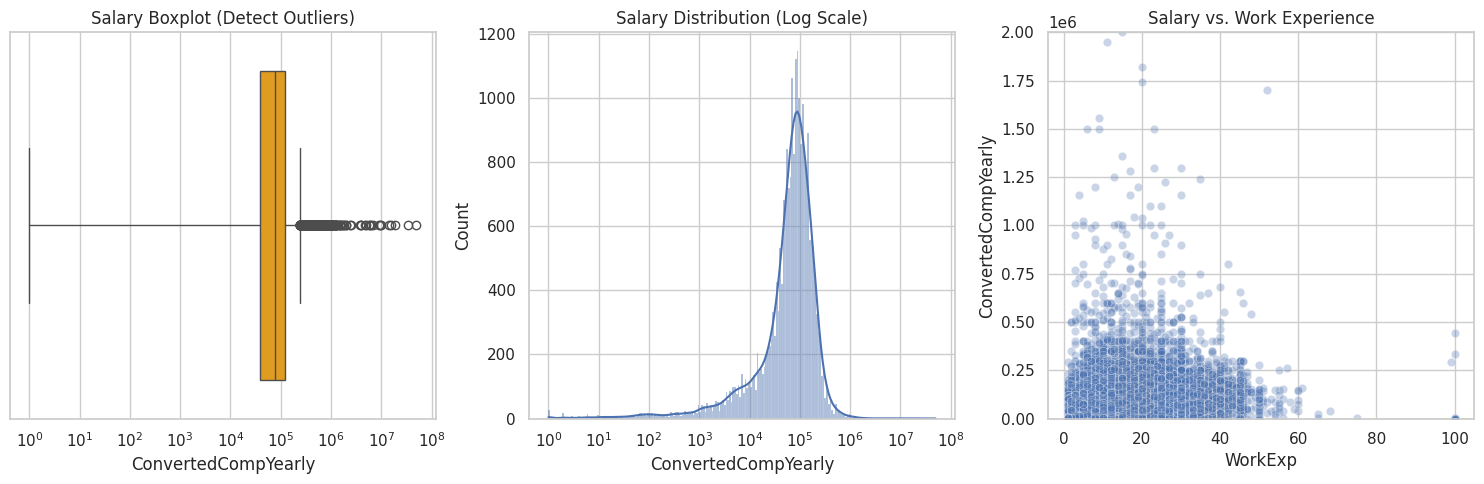

Entries with salary > $1M: 46
Entries with salary < $1k: 724


In [19]:
target_col = 'ConvertedCompYearly'
salary_data = df_analysis.loc[~nan_target_mask, target_col]

plt.figure(figsize=(15, 5))

# 1. Boxplot for Outliers
plt.subplot(1, 3, 1)
sns.boxplot(x=salary_data, color='orange')
plt.title("Salary Boxplot (Detect Outliers)")
plt.xscale('log') # Log scale helps visualize income better

# 2. Histogram for Distribution
plt.subplot(1, 3, 2)
sns.histplot(salary_data, kde=True, log_scale=True)
plt.title("Salary Distribution (Log Scale)")

# 3. Plausibility Check (Scatter vs Experience)
# Need to convert WorkExp to numeric first if it isn't already
df_analysis['WorkExp'] = pd.to_numeric(df_analysis['WorkExp'], errors='coerce')
plt.subplot(1, 3, 3)
sns.scatterplot(x=df_analysis['WorkExp'], y=salary_data, alpha=0.3)
plt.title("Salary vs. Work Experience")
plt.ylim(0, 2000000) # Limit y-axis to see the bulk of data, ignoring massive outliers for view

plt.tight_layout()
plt.show()

# Plausibility Check Logic
high_salary_count = (salary_data > 1_000_000).sum()
print(f"Entries with salary > $1M: {high_salary_count}")
print(f"Entries with salary < $1k: {(salary_data < 1000).sum()}")

## Visual Exploration (Point d)

In [20]:
# --- 2. LOGGING: Visual Exploration (Point d) ---

# Define your interpretation of the plots
visual_interpretation = """
d. Visual Exploration Findings:
   1. Distribution: 'YearsCode' is right-skewed; most devs have <15 years experience.
   2. Cardinality: 'Country' and 'DevType' have long tails (high cardinality).
   3. Outliers: Boxplots confirm extreme outliers in 'ConvertedCompYearly' (Salary).
   4. Hypothesis: Salary correlates with Experience, but outliers distort the view.
"""

vis_activity_id = "visual_exploration_bb6a40f99d924f9fbdd2b65ef6a82da2"

vis_query = [
    f':{vis_activity_id} rdf:type prov:Activity .',
    f':{vis_activity_id} rdfs:label "Visual Exploration of Data" .',
    f':{vis_activity_id} sc:isPartOf :data_understanding_phase .',
    f':{vis_activity_id} prov:startedAtTime "{now()}"^^xsd:dateTime .',
    f':{vis_activity_id} prov:wasAssociatedWith :{student_a} .',
    
    # The activity used the data
    f':{vis_activity_id} prov:used :loaded_survey_data .',
    
    # It generated a "Report" entity containing your hypothesis (Point d)
    f':visual_report_{vis_activity_id} rdf:type prov:Entity .',
    f':visual_report_{vis_activity_id} rdfs:label "Visual Interpretation Report" .',
    f':visual_report_{vis_activity_id} rdfs:comment """{visual_interpretation}""" .',
    f':visual_report_{vis_activity_id} prov:wasGeneratedBy :{vis_activity_id} .',
]

engine.insert(vis_query, prefixes=prefixes)
print("Visual Exploration Interpretation logged.")

Visual Exploration Interpretation logged.



### Summary of Issues Found
Before proceeding to the Data Preparation phase, we have identified **six critical data quality issues** that must be addressed to build a valid regression model for Salary prediction. This report outlines the issues and prescribes the necessary processing steps.

1.  **Missing Values in Target Variable (`ConvertedCompYearly`):**
    * **Issue:** A significant portion of the dataset has no recorded salary (`NaN`). This often happens when respondents choose not to share financial information.
    * **Impact:** Supervised learning models (like Regression) cannot learn from examples where the "answer" is missing.
    * **Processing Action:** **Drop all rows** where `ConvertedCompYearly` is missing. Do not attempt to fill/impute the target variable.

2.  **Extreme Outliers in Target Variable (`ConvertedCompYearly`):**
    * **Issue:** The salary distribution is heavily distorted by values reaching $50M+, which are verifiable entry errors (e.g., users entering values in local currency but selecting "USD").
    * **Impact:** These outliers will severely skew the regression line, causing the model to chase impossible values.
    * **Processing Action:** Filter out extreme outliers (e.g., drop values > $500k or the 99th percentile) to focus on the representative population.

3.  **Inverted Logic in Ranking Features (`TechEndorse`, `JobSatPoints`):**
    * **Issue:** These columns use a ranking system where `1` = "Best" and `14` = "Worst".
    * **Impact:** A regression model naturally interprets higher numbers as "more," so these features are currently inversely correlated with importance.
    * **Processing Action:** Reverse the scale (e.g., `Score = (Max_Rank + 1) - Rank`) so that higher numbers equal higher importance, and fill `NaN` rankings with `0`.

4.  **Multi-Select String Formats (`LanguageHaveWorkedWith`, `DevType`):**
    * **Issue:** Categorical data is stored as semicolon-separated strings (e.g., `"Python;SQL;Java"`).
    * **Impact:** Direct One-Hot Encoding would fail because every combination is treated as a unique category.
    * **Processing Action:** Split strings by `;` and apply **Multi-Hot Encoding** (creating binary columns for each unique item).

5.  **Ordinal Data Encoded as Strings (`Age`, `EdLevel`):**
    * **Issue:** These features represent ordered levels (e.g., "Bachelor's" < "Master's") but are stored as unordered text.
    * **Impact:** Standard encoding would destroy the ordinal relationship.
    * **Processing Action:** Manually map these strings to ordered integers (e.g., `1, 2, 3...`) to preserve the hierarchy.

6.  **High Cardinality & Open-Ended Text (`Country`):**
    * **Issue:** Some categorical columns have too many options to encode individually (e.g., 100+ countries) or contain unstructured free text (e.g., `TechEndorse_13_TEXT`).
    * **Impact:** Free text is too noisy for regression; High-cardinality columns risk overfitting and exploding the feature space (Curse of Dimensionality).
    * **Processing Action:**
        * **Free Text:** Drop these columns entirely.
        * **High Cardinality:** Apply **"Top-N Encoding"** (keep the top 15 most frequent categories, map all rare values to `"Other"`, then One-Hot Encode).

---
### Preprocessing Strategy: Handling Different Data Types

There is a crucial distinction to make when preprocessing this dataset, particularly for **Age**. While Age is conceptually numeric, it is stored as text ranges (e.g., "25-34 years old"). Treating it as standard text (splitting into binary columns) would destroy the ordinal relationship that "35-44" is older than "25-34."

Here is the corrected rule of thumb for preprocessing:

#### 1. True Numerical Values $\rightarrow$ Keep (but Scale)
These are columns that are already numbers where the magnitude matters.
* **Columns:** `WorkExp`, `YearsCode`, `ConvertedCompYearly` (Target).
* **Action:** Keep them as single columns.
* **Refinement:** For Linear Regression, apply **Scaling** (e.g., `StandardScaler` or `MinMaxScaler`) so large values (like $100,000 salary) don't overpower smaller features (like 5 years experience) purely due to magnitude.

#### 2. Ordinal Text $\rightarrow$ Map to Integers (Do NOT Split)
These are text columns that have a strictly defined order.
* **Columns:** `Age` ("18-24", "25-34"...), `EdLevel` (Bachelor's, Master's, PhD), `OrgSize`.
* **Why not binary?** Splitting `Age` into `Age_18-24` and `Age_25-34` treats them as unrelated concepts (like Apple vs. Banana). The model loses the knowledge that one is "bigger" than the other.
* **Action:** Manually map these strings to a single numeric column so the model understands the progression.
    * `"18-24"` $\rightarrow$ `1`
    * `"25-34"` $\rightarrow$ `2`
    * `"35-44"` $\rightarrow$ `3`

#### 3. Nominal Text $\rightarrow$ Split (Binary / One-Hot)
These are text columns with **no inherent order**.
* **Columns:** `Country` (Germany vs USA), `DevType` (Backend vs Frontend), `Currency`.
* **Action:** Apply **One-Hot Encoding** (using a Top-N strategy). This splits the column into multiple binary columns (e.g., `Country_USA`, `Country_Germany`, etc.).

#### 4. Multi-Select Text $\rightarrow$ Split (Multi-Hot)
These are categorical columns containing semicolon-separated lists.
* **Columns:** `LanguageHaveWorkedWith`, `DatabaseHaveWorkedWith`.
* **Action:** Split the strings and create a binary column for each unique item (e.g., `Lang_Python`, `Lang_Java`).

| Data Type in CSV | Example Column | Example Value | **Preprocessing Action** |
| :--- | :--- | :--- | :--- |
| **Numeric** | `WorkExp` | `10.0` | **Keep** (Impute & Scale) |
| **Ordinal String** | `Age` | `"25-34 years old"` | **Map to Integer** (1, 2, 3...) |
| **Ordinal String** | `EdLevel` | `"Master's degree"` | **Map to Integer** (1, 2, 3...) |
| **Nominal String** | `Country` | `"Germany"` | **One-Hot Encode** (Binary cols) |
| **Multi-Select**| `Language...` | `"Python;SQL"` | **Multi-Hot Encode** (Binary cols) |

---
### Data Processing To-Do List

Based on the findings from the Data Understanding phase, the following actions are required to prepare the dataset for Linear Regression.

#### 1. Data Cleaning & Filtering
* [ ] **Target Variable (`ConvertedCompYearly`):** Drop all rows where the target variable is missing (`NaN`).
* [ ] **Outlier Removal:** Filter out rows with extreme salary values (e.g., values > $500,000 USD or exceeding the 99th percentile) to prevent skewing the regression line.
* [ ] **Drop Noisy Features:** Remove all unstructured text columns (those ending in `_TEXT` or `_Other`) as they add noise without significant predictive value for this model.

#### 2. Feature Engineering & Encoding
* [ ] **Ordinal Encoding (Preserve Order):**
    * Map **`Age`** ranges to ordered integers (e.g., "18-24" $\rightarrow$ 1, "25-34" $\rightarrow$ 2).
    * Map **`EdLevel`** and **`OrgSize`** to hierarchical integers to preserve magnitude.
* [ ] **Nominal Encoding (Top-N Strategy):**
    * For high-cardinality columns like **`Country`**, **`DevType`**, and **`Currency`**: Keep the top 15 most frequent categories; map all others to a single `"Other"` bucket.
    * Apply **One-Hot Encoding** to these consolidated categories.
* [ ] **Multi-Select Encoding (Multi-Hot):**
    * For list columns like **`LanguageHaveWorkedWith`** and **`DatabaseHaveWorkedWith`**: Split strings by the semicolon delimiter (`;`) and create binary columns (0/1) for each unique technology.
* [ ] **Logic Inversion:**
    * For ranking columns like **`TechEndorse`** and **`JobSatPoints`**: Reverse the values so higher numbers indicate higher importance (e.g., `Score = 15 - Rank`). Replace `NaN` with 0.

#### 3. Scaling & Imputation
* [ ] **Numeric Imputation:** Fill missing values in continuous columns like **`WorkExp`** and **`YearsCode`** (e.g., using the Median value).
* [ ] **Feature Scaling:** Apply **StandardScaler** or **MinMaxScaler** to all true numeric features (Experience, Salary, etc.) to ensure that features with larger magnitudes do not disproportionately influence the Linear Regression weights.

### Manual Qualitative Assessment (Points e, f, g)

In [21]:
assess_activity_id = "d0c7d6a1-1f6c-4d1e-9b58-0b7d8e4bfebb"

# --- 1. CLEAN TEXT CONTENT ---
# We strip out potential problem characters (like LaTeX arrows) and use standard ASCII
# The graph doesn't render LaTeX anyway, so standard text is better.

ethical_text = """
e. Ethical & Bias Evaluation:
   - Sensitive Attributes: Age, Country (Origin), EdLevel.
   - Representation Bias: Western countries are overrepresented.
   - Minority Groups: Gender (if present) and non-English speakers might be underrepresented.
"""

risk_text = """
f. Risks & External Questions:
   - Risk: Model might bias against low-cost-of-living countries.
   - Risk: 'Vibe Coding' answers might correlate with age, creating ageism bias.
   - Expert Q: Should we use Purchasing Power Parity (PPP) to normalize salaries?
"""

action_plan_text = """
g. Preparation Action Plan:
   - Remove: Remove Columns where target is not available.
   - Filter: Cap Salary outliers (e.g. 1k to 500k range).
   - Impute: Median for numeric features (WorkExp).
   - Encode: Top-N One-Hot for Country; Multi-Hot for Languages.
   - Engineer: Reverse rank ordering for 'TechEndorse'.
"""

# Serialize to safe JSON strings (adds quotes and escapes newlines automatically)
# This prevents syntax errors in the SPARQL query.
ethical_safe = json.dumps(ethical_text)[1:-1] # [1:-1] removes the outer quotes added by json.dumps
risk_safe = json.dumps(risk_text)[1:-1]
action_safe = json.dumps(action_plan_text)[1:-1]


# --- 2. GENERATE NEW ID ---
current_time = now()

assess_query = [
    f':{assess_activity_id} rdf:type prov:Activity .',
    f':{assess_activity_id} rdfs:label "Qualitative Assessment" .',
    f':{assess_activity_id} sc:isPartOf :data_understanding_phase .',
    f':{assess_activity_id} prov:wasAssociatedWith :{student_a} .',
    f':{assess_activity_id} prov:startedAtTime "{current_time}"^^xsd:dateTime .',
    
    # Point e: Ethics
    f':report_ethics_{assess_activity_id} rdf:type prov:Entity .',
    f':report_ethics_{assess_activity_id} rdfs:comment "{ethical_safe}" .', # Use single quotes with safe text
    f':report_ethics_{assess_activity_id} prov:wasGeneratedBy :{assess_activity_id} .',

    # Point f: Risks
    f':report_risks_{assess_activity_id} rdf:type prov:Entity .',
    f':report_risks_{assess_activity_id} rdfs:comment "{risk_safe}" .',
    f':report_risks_{assess_activity_id} prov:wasGeneratedBy :{assess_activity_id} .',

    # Point g: Action Plan
    f':report_actions_{assess_activity_id} rdf:type prov:Entity .',
    f':report_actions_{assess_activity_id} rdfs:comment "{action_safe}" .',
    f':report_actions_{assess_activity_id} prov:wasGeneratedBy :{assess_activity_id} .',
]

engine.insert(assess_query, prefixes=prefixes)
print(f"✅ Qualitative Assessment logged with ID: {assess_activity_id}")

✅ Qualitative Assessment logged with ID: d0c7d6a1-1f6c-4d1e-9b58-0b7d8e4bfebb


## Data Preparation

In [22]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
f':data_preparation_phase rdf:type prov:Activity .',
f':data_preparation_phase rdfs:label "Data Preparation Phase" .', 
]
engine.insert(data_preparation_phase_executor, prefixes=prefixes)

In [23]:
handle_outliers_code_writer = student_b
def handle_outliers(df:pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
    # REMOVE OUTLIERS
    return df

start_time_td = now()
handle_outliers(data, outliers_report)
end_time_td = now()

#############################################
# Documentation
#############################################
# This is the continuation of the example from the Data Understanding phase above.
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => already done in data understanding phase
# 2. activity inspects the outcome and derives decisions => already done in data understanding phase
# 3. activity follows up on the decision by changing the data => in this case by removing the the outliers that were found

ro_ass_uuid_executor = "ec7e81e1-86ea-475a-a8d4-c7d8ee535488"
handle_outliers_executor = [
    f':handle_outliers prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(handle_outliers_executor, prefixes=prefixes)

td_ass_uuid_writer = "1405f15a-3545-4014-a962-637f3c10a137"
td_comment = """
Removing all outliers that were identifying in the Data Understanding Phase.
"""
handle_outliers_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    ':handle_outliers rdfs:comment \'Data Preparation\' .', 
    f':handle_outliers rdfs:comment """{td_comment}""" .', 
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{handle_outliers_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_outliers prov:used :data .',
    ':handle_outliers prov:used :outlier_decision .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_outliers .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
engine.insert(handle_outliers_activity, prefixes=prefixes)

**Continue with other tasks of the Data Preparation phase such as binning, scaling etc...**

In [24]:
# Your final transformed dataset should also be documented appropriately using Croissant, SI, etc.

prepared_data_triples = [
    ':prepared_data rdf:type prov:Entity .',
    ':prepared_data prov:wasDerivedFrom :cleaned_data .',
    ':prepared_data rdf:type sc:Dataset .',
    # ....
]
engine.insert(prepared_data_triples, prefixes=prefixes)

## Modeling

In [25]:
## Each Activity that follows is part of the Modeling Phase

modeling_phase_executor = [
f':modeling_phase rdf:type prov:Activity .',
f':modeling rdfs:label "Modeling Phase" .', 
]
engine.insert(modeling_phase_executor, prefixes=prefixes)


In [26]:
model_data_code_writer = student_a

#############################################
# Documentation 4a
#############################################

dma_ass_uuid_writer = "b3e840ab-ac23-415e-bd9c-6d00bb79c37a"
dma_comment = """
...
"""

identify_data_mining_algorithm_activity = [
    f':define_algorithm rdf:type prov:Activity .',
    f':define_algorithm sc:isPartOf :modeling_phase .',
    f':define_algorithm rdfs:comment """{dma_comment}""" .',
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',
    f':{dma_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{dma_ass_uuid_writer} rdf:type prov:Association .',
    f':{dma_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example algorithm definition
    f':random_forest_algorithm rdf:type mls:Algorithm .',
    f':random_forest_algorithm rdfs:label "Random Forest Algorithm" .',

    # example implementation
    f':random_forrest_classifier_implementation rdf:type mls:Implementation .',
    f':random_forrest_classifier_implementation rdfs:label "Scikit-learn RandomForestClassifier" .',
    f':random_forrest_classifier_implementation mls:implements :random_forest_algorithm .',
    f':random_forrest_classifier_implementation prov:wasGeneratedBy :define_algorithm .',

    
    # you can also define your Evaluation Measures here
    
    # example evaluation 
    f':r2_score_measure rdf:type mls:EvaluationMeasure .',
    f':r2_score_measure rdfs:label "R-squared Score" .',
    f':r2_score_measure rdfs:comment "xxx" .',
    f':r2_score_measure prov:wasGeneratedBy :define_algorithm .',

    
]
engine.insert(identify_data_mining_algorithm_activity, prefixes=prefixes)

In [27]:
#############################################
# Documentation 4b
#############################################

hp_ass_uuid_writer = "fff582a8-c5cd-4030-978b-9f56b603167c"
hp_comment = """
...
"""
identify_hp_activity = [
    f':identify_hyperparameters rdf:type prov:Activity .',
    f':identify_hyperparameters sc:isPartOf :modeling_phase .',
    f':identify_hyperparameters rdfs:comment """{hp_comment}""" .',
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_writer} .',
    f':{hp_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{hp_ass_uuid_writer} rdf:type prov:Association .',
    f':{hp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example parameter
    f':hp_learning_rate rdf:type mls:HyperParameter .',
    f':hp_learning_rate rdfs:label "Learning Rate" .',
    f':hp_learning_rate rdfs:comment "..." .',
    f':random_forrest_classifier_implementation mls:hasHyperParameter :hp_learning_rate .',
    f':hp_learning_rate prov:wasGeneratedBy :identify_hyperparameters .',

    # continue with your identified hyperparameters
    
]
engine.insert(identify_hp_activity, prefixes=prefixes)

In [28]:
def split_data(df: pd.DataFrame):
    #do something
    return 'train_set', 'validation_set', 'test_set'

#############################################
# Documentation 4c
#############################################

### Define Train/Validation/Test splits
split_ass_uuid_writer = "fb58ae6c-9d58-44c9-ac7e-529111bdf7fc"
split_comment = """
...
"""
## Use your prepared dataset
input_dataset = ":prepared_data" 

define_split_activity = [
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:comment "Train/Validation/Test Split Definition" .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    f':define_data_split prov:used {input_dataset} .',
    
    # Training Set
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains xx samples" .', 

    # Validation Set
    f':validation_set rdf:type sc:Dataset .',
    f':validation_set rdfs:label "Validation Set" .',
    f':validation_set prov:wasGeneratedBy :define_data_split .',
    f':validation_set prov:wasDerivedFrom {input_dataset} .',
    f':validation_set rdfs:comment "Contains xx samples" .', 

    # Test Set
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Test Set" .',
    f':test_set prov:wasGeneratedBy :define_data_split .',
    f':test_set prov:wasDerivedFrom {input_dataset} .',
    f':test_set rdfs:comment "Contains xx samples" .', 

    
]
engine.insert(define_split_activity, prefixes=prefixes)

In [29]:
def train_and_finetune_model(training_set, validation_set):
    # do something here

    # Try to automate as much documentation work as possible.
    # Define your training runs with their respective hyperparameter settings, etc.
    # Document each time a training run, model, its hp_settings, evaluations, ...  
    # Create performance figures/graphs

    return 'Find most suitable model'


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4d & e & f
#############################################

tafm_ass_uuid_writer = "21d60fe3-c9ab-4a0a-bae7-b9fe9653c755"
tafm_comment = """
...
"""

# EXAMPLE output from your training
training_run1 = "run_1" 
model_run1 = "model_run1"
hp1_setting_run1 = "hp_setting_run1"
eval_train_run1 = "metric_train_run1"
eval_validation_run1 = "metric_validation_run1"


train_model_activity = [
    # Activity 
    f':train_and_finetune_model rdf:type prov:Activity .',
    f':train_and_finetune_model sc:isPartOf :modeling_phase .',
    f':train_and_finetune_model rdfs:comment """{tafm_comment}""" .',
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',
    f':{tafm_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
    f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    ########################################
    # ONE model run - automate everything below!

    # Parameter settings
    f':{hp1_setting_run1} rdf:type mls:HyperParameterSetting .',
    f':{hp1_setting_run1} mls:specifiedBy :hp_learning_rate .',
    f':{hp1_setting_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{hp1_setting_run1} prov:wasGeneratedBy :train_and_finetune_model .',
    # add your further parameters

    # Describe your Run
    f':{training_run1} rdf:type mls:Run .',
    f':{training_run1} sc:isPartOf :train_and_finetune_model .',
    f':{training_run1} mls:realizes :random_forest_algorithm .',
    f':{training_run1} rdf:label "Training Run 1 with..." .',
    f':{training_run1} mls:executes :your_implementation .', 
    f':{training_run1} mls:hasInput :training_set .',
    f':{training_run1} mls:hasInput :validation_set .',
    f':{training_run1} mls:hasInput :{hp1_setting_run1} .',     
    # list all your used parameters here
    f':{training_run1} mls:hasOutput :{model_run1} .',
    f':{training_run1} mls:hasOutput :{eval_train_run1} .',
    f':{training_run1} mls:hasOutput :{eval_validation_run1} .',

    # Describe your Model
    f':{model_run1} rdf:type mls:Model .',
    f':{model_run1} prov:label "xxx" .',
    f':{model_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{model_run1} mlso:trainedOn :training_set .',
    f':{model_run1} mlso:hasAlgorithmType :random_forest_algorithm .',

    # Describe your evaluations
    # You can have multiple evaluations per model 
    f':{eval_train_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_train_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_train_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_train_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_train_run1} prov:used :training_set .',

    f':{eval_validation_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_validation_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_validation_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_validation_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_validation_run1} prov:used :validation_set .',

    # Dont forget to document any visualizations

]
engine.insert(train_model_activity, prefixes=prefixes)


In [30]:
def retrain_model_full_data(training_set, validation_set):
    
    # create your
    return "Final Trained Model"


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4g
#############################################

retrain_ass_uuid_writer = "96815ee0-524c-437b-b5fa-2e15b945c993" # Generate once

final_training_activity = ":retrain_final_model"
final_model = ":final_model_entity"

# Document the retraining activity.
# Hint: This activity is still part of the :modeling_phase

retrain_documentation = [
    # your documentation here    
]
engine.insert(retrain_documentation, prefixes=prefixes)


## Evaluation

In [31]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
f':evaluation_phase rdf:type prov:Activity .',
f':evaluation_phase rdfs:label "Evaluation Phase" .', 
]
engine.insert(evaluation_phase_executor, prefixes=prefixes)

In [32]:
eval_code_writer = student_b
def evaluate_on_test_data(final_model, test_set):

    # Predict and evaluation on test data
        
    return 'Performance'

start_time_eval = now()
#evaluate_on_test_data()
end_time_eval = now() 

#############################################
# Documentation
#############################################

eval_ass_uuid = "7f1431e9-feed-429a-92ed-c131b23cbe79" # Generate once
final_model = ":final_model_entity" 
test_set = ":test_set" 

eval_comment = """
...
"""

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',
    
    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model prov:used {final_model} .',
    f':evaluate_final_model prov:used {test_set} .',
    
    # Reference to Data Mining Success Criteria from Phase 1
    f':evaluate_final_model prov:used :bu_data_mining_success_criteria .',

    # Document you final model performance
 
    # Hint: you evaluate bias in this way:
    f':bias_evaluation_result rdf:type mls:ModelEvaluation .',
    f':bias_evaluation_result prov:wasGeneratedBy :evaluate_final_model .',
    f':bias_evaluation_result rdfs:label "Bias Analysis" .',
    f':bias_evaluation_result rdfs:comment "..." .',
    
]
engine.insert(evaluate_activity, prefixes=prefixes)

## Deployment

In [33]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
f':deployment_phase rdf:type prov:Activity .',
f':deployment_phase rdfs:label "Deployment Phase" .', 
]
engine.insert(deployment_phase_executor, prefixes=prefixes)

In [34]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
...
"""

ethical_aspects_comment = """
...
"""

monitoring_plan_comment = """
...
"""

reproducibility_reflection_comment = """
...
"""

dep_ass_uuid_executor = "72a921e0-1234-4567-89ab-cdef01234567" # Generate once
deployment_executor = [
f':plan_deployment rdf:type prov:Activity .',
f':plan_deployment sc:isPartOf :deployment_phase .', # Connect to Parent Phase
f':plan_deployment rdfs:label "Plan Deployment"@en .',

f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
f':{dep_ass_uuid_executor} rdf:type prov:Association .',
f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]
engine.insert(deployment_executor, prefixes=prefixes)


deployment_data_executor = [
#6a
f':dep_recommendations rdf:type prov:Entity .',
f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
#6b
f':dep_ethical_risks rdf:type prov:Entity .',
f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
#6c
f':dep_monitoring_plan rdf:type prov:Entity .',
f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
#6d
f':dep_reproducibility_reflection rdf:type prov:Entity .',
f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
engine.insert(deployment_data_executor, prefixes=prefixes)

# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [35]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/"

In [36]:
# This cell includes cleaning functions

from datetime import datetime

def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [37]:
# This cell includes exemplary queries for different phases


### Author Block
author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query)
author_block_latex = ""

if not res_authors.empty: # type:ignore
    for _, row in res_authors.iterrows(): # type:ignore

        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"
        
        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """

### Business Understanding example
bu_query = f"""
{prefix_header}

SELECT ?ds_comment ?bo_comment WHERE {{
  OPTIONAL {{ :bu_data_source_and_scenario rdfs:comment ?ds_comment . }}
  OPTIONAL {{ :bu_business_objectives rdfs:comment ?bo_comment . }}
}} LIMIT 1
"""
res_bu = engine.query(bu_query)
row_bu = res_bu.iloc[0] if not res_bu.empty else {} # type:ignore
bu_data_source = latex_escape(clean_rdf(row_bu.get("ds_comment", "")))
bu_objectives  = latex_escape(clean_rdf(row_bu.get("bo_comment", "")))


### Data Understanding examples
# Example Dataset Description
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query)
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {} # type:ignore
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# Example Feature Columns Table
du_query = f"""
{prefix_header}

SELECT ?name (SAMPLE(?dtypeRaw) as ?dtype) (SAMPLE(?descRaw) as ?desc) WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  ?field sc:description ?descRaw .
  ?field cr:dataType ?dtypeRaw .
}} 
GROUP BY ?name
ORDER BY ?name
"""
res_du = engine.query(du_query)
du_rows = []
if not res_du.empty: # type:ignore
    for _, f in res_du.iterrows(): # type:ignore
        dtype_raw = clean_rdf(f.get("dtype", ""))
        if '#' in dtype_raw: dtype = dtype_raw.split('#')[-1]
        elif '/' in dtype_raw: dtype = dtype_raw.split('/')[-1]
        else: dtype = dtype_raw
        
        desc = clean_rdf(f.get("desc", ""))
        row_str = f"{latex_escape(clean_rdf(f['name']))} & {latex_escape(dtype)} & {latex_escape(desc)} \\\\"
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)

### Modeling example
# Hyperparameters
hp_query = f"""
{prefix_header}

SELECT ?hpName (SAMPLE(?hpValRaw) as ?hpVal) (MAX(?hpDescRaw) as ?hpDesc) WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?setting .
  ?setting a mls:HyperParameterSetting .
  ?setting mls:hasValue ?hpValRaw .
  ?setting mls:specifiedBy ?hpDef .
  ?hpDef rdfs:label ?hpName .
  OPTIONAL {{ ?hpDef rdfs:comment ?hpDescRaw . }}
}} 
GROUP BY ?hpName
ORDER BY ?hpName
"""
res_hp = engine.query(hp_query)
hp_rows = []
if not res_hp.empty: #type:ignore
    for _, row in res_hp.iterrows(): #type:ignore
        name = latex_escape(clean_rdf(row['hpName']))
        val  = latex_escape(clean_rdf(row['hpVal']))
        desc = latex_escape(clean_rdf(row.get('hpDesc', '')))
        hp_rows.append(rf"{name} & {desc} & {val} \\")

hp_table_rows = "\n    ".join(hp_rows)

# Run Info
run_query = f"""
{prefix_header}

SELECT ?algoLabel ?start ?end ?metricLabel ?metricVal WHERE {{
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  OPTIONAL {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  OPTIONAL {{
    ?run sc:isPartOf :train_and_finetune_model .
    ?run mls:hasOutput ?eval .
    ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
    OPTIONAL {{ ?eval mls:specifiedBy ?m . ?m rdfs:label ?metricLabel . }}
  }}
}} LIMIT 1
"""
res_run = engine.query(run_query)
row_run = res_run.iloc[0] if not res_run.empty else {} #type:ignore
mod_algo  = latex_escape(clean_rdf(row_run.get("algoLabel", "")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end   = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "")))
raw_val = clean_rdf(row_run.get('metricVal', ''))
mod_m_val = f"{float(raw_val):.4f}" if raw_val else ""

print("Data extraction done.")

HTTPError: HTTP Error 504: Gateway Time-out

The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [ ]:
latex_content = rf"""\documentclass[sigconf]{{acmart}}

\AtBeginDocument{{ \providecommand\BibTeX{{ Bib\TeX }} }}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{XXXXXXX.XXXXXXX}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Experiment Report - Group {group_id}}}
%% ---Authors: Dynamically added ---
{author_block_latex}

\begin{{abstract}}
  This report documents the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}

\subsection{{Data Source and Scenario}}
{bu_data_source}

\subsection{{Business Objectives}}
{bu_objectives}

%% --- 2. Data Understanding ---
\section{{Data Understanding}}
\textbf{{Dataset Description:}} {du_description}

The following features were identified in the dataset:

\begin{{table}}[h]
  \caption{{Raw Data Features}}
  \label{{tab:features}}
  \begin{{tabular}}{{lp{{0.2\linewidth}}p{{0.4\linewidth}}}}
    \toprule
    \textbf{{Feature Name}} & \textbf{{Data Type}} & \textbf{{Description}} \\
    \midrule
    {du_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

%% --- 3. Data Preparation ---
\section{{Data Preparation}}
\subsection{{Data Cleaning}}
Describe your Data preparation steps here and include respective graph data.


%% --- 4. Modeling ---
\section{{Modeling}}

\subsection{{Hyperparameter Configuration}}
The model was trained using the following hyperparameter settings:

\begin{{table}}[h]
  \caption{{Hyperparameter Settings}}
  \label{{tab:hyperparams}}
  \begin{{tabular}}{{lp{{0.4\linewidth}}l}}
    \toprule
    \textbf{{Parameter}} & \textbf{{Description}} & \textbf{{Value}} \\
    \midrule
    {hp_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

\subsection{{Training Run}}
A training run was executed with the following characteristics:
\begin{{itemize}}
    \item \textbf{{Algorithm:}} {mod_algo}
    \item \textbf{{Start Time:}} {mod_start}
    \item \textbf{{End Time:}} {mod_end}
    \item \textbf{{Result:}} {mod_m_lbl} = {mod_m_val}
\end{{itemize}}

%% --- 5. Evaluation ---
\section{{Evaluation}}

%% --- 6. Deployment ---
\section{{Deployment}}

\section{{Conclusion}}

\end{{document}}
"""

In [ ]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")